A simple 2-node simulation demonstration the application of GP-CaKe. Of particular interest are the covariance parameters
that define the constraints on the posterior shape of the causal kernels.

References:
    Ambrogioni, L., Hinne, M., van Gerven, M., & Maris, E. (2017). GP CaKe: Effective brain connectivity with causal kernels,
    pp. 1–10. Retrieved from http://arxiv.org/abs/1705.05603

Last updated on July 6th, 2017.

In [1]:
%matplotlib inline
import numpy as np

"""
Simulation and GP-CaKe packages.
"""

import simulator as sim
import gpcake
import utility

Construction of simulated time series data. Here, we start with a 2-node graph with one connection (with max. strength <connection_strength>).

We create a 4 second time series per node, with a sampling rate of 100 Hz. <ntrials_train> trials are then generated to train the dynamic parameters on, and <ntrials_test> to learn the GP posterior.

In [2]:
p                       = 2
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
connection_strength     = 1.0
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
n                       = int(time_period / time_step)
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

ntrials_train                                       = 200
ntrials_test                                        = 200
simulation                                          = sim.integroDifferential_simulator()

(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, 
                                                                                           ntrials_test, 
                                                                                           simulation_params)

Plot a few samples to see the generated time series.

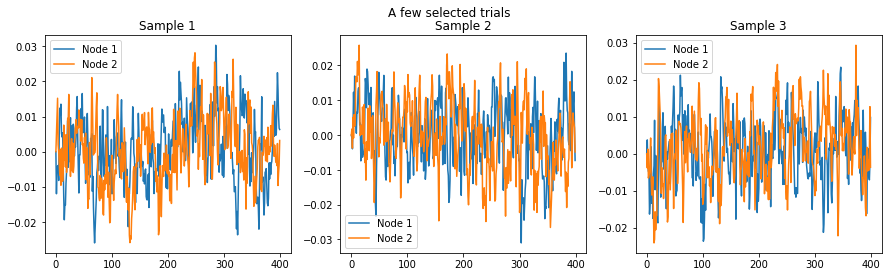

In [3]:
utility.plot_samples(training_samples[0:3])

Simulation is done. Time to bake some cake!

Set up the GP CaKe object and initialize. Currently implemented types of dynamics are 'Relaxation' and 'Oscillation'.

In [4]:
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"

Optimize the univariate likelihoods for each node for the dynamic parameters using a grid search.

In [5]:
dynamic_parameters_range = {}
dynamic_parameters_range["relaxation_constant"] = {}
dynamic_parameters_range["relaxation_constant"]["step"] = 2
dynamic_parameters_range["relaxation_constant"]["min"] = 20
dynamic_parameters_range["relaxation_constant"]["max"] = 50
dynamic_parameters_range["amplitude"] = {}
dynamic_parameters_range["amplitude"]["step"] = 0.001
dynamic_parameters_range["amplitude"]["min"] = 0.005
dynamic_parameters_range["amplitude"]["max"] = 0.015

cake.learn_dynamic_parameters(training_samples, dynamic_parameters_range)

Set the parameters of the causal kernel.

In [6]:
cake.covariance_parameters = {  "time_scale"        : 0.15,     # Temporal smoothing
                                "time_shift"        : 0.05,     # Temporal offset
                                "causal"            : "yes",    # Hilbert transform
                                "spectral_smoothing": np.pi }   # Temporal localization
cake.noise_level = 0.05

Compute the posteriors for each of the p*(p-1) connections.

In [7]:
connectivity = cake.run_analysis(testing_samples)

/home/johan/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


Visualize the posterior kernels.

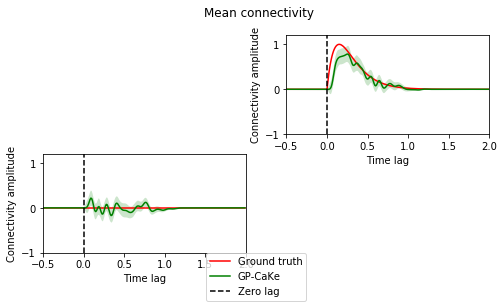

In [8]:
utility.plot_connectivity(ground_truth, connectivity, time_range, t0=-0.5)